## PCA
[PCA详细讲解](http://blog.codinglabs.org/articles/pca-tutorial.html)

In [5]:
import numpy as np
def zeroMean(dataMat):
    meanVal = np.mean(dataMat,axis=0)
    newData = dataMat - meanVal
    return newData,meanVal
    
testMat = [[1,2,4],[3,4,5]]
def pca(dataMat,n):
    newData, meanVal = zeroMean(testMat)
    # 求协方差矩阵
    covMat = np.cov(newData,rowvar=0)
    # 求特征值和特征向量
    eigVals,eigVects=np.linalg.eig(np.mat(covMat))
    eigValIndice=np.argsort(eigVals)            #对特征值从小到大排序
    n_eigValIndice=eigValIndice[-1:-(n+1):-1]   #最大的n个特征值的下标
    n_eigVect=eigVects[:,n_eigValIndice]        #最大的n个特征值对应的特征向量
    lowDDataMat=newData*n_eigVect               #低维特征空间的数据
    reconMat=(lowDDataMat*n_eigVect.T)+meanVal  #重构数据
    return lowDDataMat,reconMat
pca(testMat,2)

old_index [1 2]
new_index [1 2]


(matrix([[-1.5,  0. ],
         [ 1.5,  0. ]]),
 matrix([[1., 2., 4.],
         [3., 4., 5.]]))

(150, 4)
(150, 4)
kshape (150, 150)
[5.89831214 5.10991178 3.36044095 2.8231392  2.72151658]


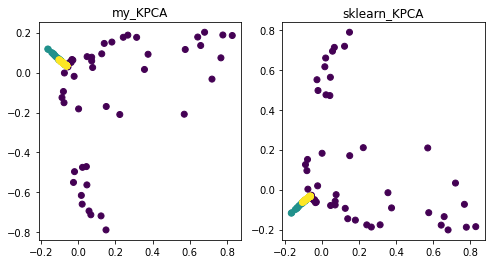

In [2]:
# coding:utf-8
# 实现KPCA

from sklearn.datasets import load_iris
from sklearn.decomposition import KernelPCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def sigmoid(x, coef = 0.25):
    x = np.dot(x, x.T)
    return np.tanh(coef*x+1)

def linear(x):
    x = np.dot(x, x.T)
    return x

# 径向基核函数RBF（高斯核函数）
def rbf(x, gamma = 15):
    # 计算向量间欧式距离的平方，共计算C_(150)^2次
    print(x.shape)
    sq_dists = pdist(x, 'sqeuclidean')
    # 用来把一个向量格式的距离向量转换成一个方阵格式的距离矩阵
    mat_sq_dists = squareform(sq_dists)
    return np.exp(-gamma*mat_sq_dists)

def kpca(data, n_dims=5, kernel = rbf):
    '''
    :param data: (n_samples, n_features)
    :param n_dims: target n_dims
    :param kernel: kernel functions
    :return: (n_samples, n_dims)
    '''
    K = kernel(data)
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    # 此式相当于将公式4.2代入到4.3中化简得结果
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    # 下面求C特征向量
    eig_values, eig_vector = np.linalg.eig(K)
    # 获得特征值降序索引
    idx = eig_values.argsort()[::-1]
    eigval = eig_values[idx][:n_dims]
    eigvector = eig_vector[:, idx][:, :n_dims]
    print(eigval)
    eigval = eigval**(1/2)
    # 标准化特征向量，使其成为新空间的基底
    vi = eigvector/eigval.reshape(-1,n_dims)
    data_n = np.dot(K, vi)
    return data_n


if __name__ == "__main__":
    data = load_iris().data
    Y = load_iris().target
    print(data.shape)
    data_1 = kpca(data, kernel=rbf)

    sklearn_kpca = KernelPCA(n_components=5, kernel="rbf", gamma=15)
    data_2 = sklearn_kpca.fit_transform(data)

    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.title("my_KPCA")
    plt.scatter(data_1[:, 0], data_1[:, 1], c = Y)

    plt.subplot(122)
    plt.title("sklearn_KPCA")
    plt.scatter(data_2[:, 0], data_2[:, 1], c = Y)
    plt.show()

max_dist 5935.0
eig_val[:10]:  [-4.59701721e-17  2.91631146e-03  6.65082203e-03  9.90821980e-03
  1.27832277e-02  1.33949749e-02  2.31575990e-02  2.53186872e-02
  3.87587872e-02  4.51036101e-02]
j:  1
[0.00291631 0.00665082]
[[1.40711219e+01 1.23675050e-13]
 [1.23673749e-13 1.26249455e+01]]


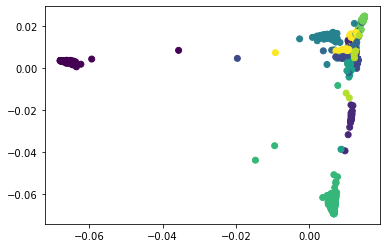

In [1]:
# coding:utf-8

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from mpl_toolkits.mplot3d import Axes3D

def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

def rbf(dist, t = 1.0):
    '''
    rbf kernel function
    '''
    return np.exp(-(dist/t))

def cal_pairwise_dist(x):

    '''计算pairwise 距离, x是matrix
    (a-b)^2 = a^2 + b^2 - 2*a*b
    '''
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    #返回任意两个点之间距离的平方
    return dist

def cal_rbf_dist(data, n_neighbors = 10, t = 1):

    dist = cal_pairwise_dist(data)
    dist[dist < 0] = 0
    n = dist.shape[0]
    rbf_dist = rbf(dist, t)

    W = np.zeros((n, n))
    for i in range(n):
        index_ = np.argsort(dist[i])[1:1+n_neighbors]
        W[i, index_] = rbf_dist[i, index_]
        W[index_, i] = rbf_dist[index_, i]

    return W

def le(data,
          n_dims = 2,
          n_neighbors = 5, t = 1.0):
    '''
    :param data: (n_samples, n_features)
    :param n_dims: target dim
    :param n_neighbors: k nearest neighbors
    :param t: a param for rbf
    :return:
    '''
    N = data.shape[0]
    W = cal_rbf_dist(data, n_neighbors, t)  # 构造权值矩阵
    D = np.zeros_like(W)
    for i in range(N):
        D[i,i] = np.sum(W[i])

    D_inv = np.linalg.inv(D)
    L = D - W  # 计算拉普拉斯矩阵L
    eig_val, eig_vec = np.linalg.eig(np.dot(D_inv, L))

    sort_index_ = np.argsort(eig_val)

    eig_val = eig_val[sort_index_]
    print("eig_val[:10]: ", eig_val[:10])

    j = 0
    while eig_val[j] < 1e-6:
        j+=1

    print("j: ", j)

    sort_index_ = sort_index_[j:j+n_dims]
    eig_val_picked = eig_val[j:j+n_dims]
    print(eig_val_picked)
    eig_vec_picked = eig_vec[:, sort_index_]

    # print("L: ")
    # print(np.dot(np.dot(eig_vec_picked.T, L), eig_vec_picked))
    # print("D: ")
    # D not equal I ???
    print(np.dot(np.dot(eig_vec_picked.T, D), eig_vec_picked))

    X_ndim = eig_vec_picked
    return X_ndim

if __name__ == '__main__':
    # X, Y = make_swiss_roll(n_samples = 2000)
    # X_ndim = le(X, n_neighbors = 5, t = 20)
    #
    # fig = plt.figure(figsize=(12,6))
    # ax1 = fig.add_subplot(121, projection='3d')
    # ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c = Y)
    #
    # ax2 = fig.add_subplot(122)
    # ax2.scatter(X_ndim[:, 0], X_ndim[:, 1], c = Y)
    # plt.show()

    X = load_digits().data
    y = load_digits().target

    dist = cal_pairwise_dist(X)
    max_dist = np.max(dist)
    print("max_dist", max_dist)
    X_ndim = le(X, n_neighbors = 20, t = max_dist*0.1)
    plt.scatter(X_ndim[:, 0], X_ndim[:, 1], c = y)
    plt.savefig("LE2.png")
    plt.show()

In [3]:
from PIL import Image
import numpy as np
import os
img_data = []
content_path = 'data/'
for file in os.listdir(content_path):
    # 拼接完整文件路径
    cmp_path = os.path.join(content_path,file)
    I = Image.open(cmp_path)
    tmp_img = np.array(I.convert('L'))
    img_data.append(tmp_img)
data = np.array(img_data)
print(data.shape)

(200, 112, 92)


## 2DPCA

In [4]:
# 通过2DPCA得到投影矩阵
def TwoDPCA(imgs,n_dims):
    # imgs为三维矩阵，第一维为图片个数,n_dims为降维之后的维度
    a,b,c = imgs.shape
    # 求平均值矩阵
    average = np.zeros((b,c))
    for i in range(a):
        average += imgs[i,:,:]/(a*1.0)
    G_t = np.zeros((b,b))
    for j in range(a):
        img = imgs[j,:,:]
        # 均值归0
        temp = img-average
        G_t = G_t + np.dot(temp,temp.T)/(a*1.0)
    eig_values,eig_vector = np.linalg.eigh(G_t)
    idx = eig_values.argsort()[::-1]
    eigval = eig_values[idx][:n_dims]
    eigvector = eig_vector[:, idx][:, :n_dims]
    print(G_t.shape)
    data_n = [np.dot(eigvector.T, emp) for emp in imgs]
    return np.array(data_n)


# 径向基核函数RBF（高斯核函数）
def rbf(x, gamma = 15):
    # 计算向量间欧式距离的平方，共计算C_(150)^2次
    sq_dists = pdist(x, 'sqeuclidean')
    # 用来把一个向量格式的距离向量转换成一个方阵格式的距离矩阵
    mat_sq_dists = squareform(sq_dists)
    return np.exp(-gamma*mat_sq_dists)

def kpca(data, n_dims=2, kernel = rbf):
    '''
    :param data: (n_samples, n_features)
    :param n_dims: target n_dims
    :param kernel: kernel functions
    :return: (n_samples, n_dims)
    '''
    K = kernel(data)
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    # 此式相当于将公式4.2代入到4.3中化简得结果
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    # 下面求C特征向量
    eig_values, eig_vector = np.linalg.eig(K)
    # 获得特征值降序索引
    idx = eig_values.argsort()[::-1]
    eigval = eig_values[idx][:n_dims]
    eigvector = eig_vector[:, idx][:, :n_dims]
    print(eigval)
    eigval = eigval**(1/2)
    # 标准化特征向量，使其成为新空间的基底
    vi = eigvector/eigval.reshape(-1,n_dims)
    data_n = np.dot(K, vi)
    return data_n

In [5]:
result = TwoDPCA(data,5)

(112, 112)


In [6]:
result.shape

(200, 5, 92)

### PCA和2DPCA的区别
* PCA将二维图像矩阵变成向量的形式
* 2DPCA将图像矩阵的一行直接作为训练样本

In [ ]:
# K2DPCA的实现
def K2DPCA(data, ndims=2, kernel=rbf):
    # data为三维灰度图数据
    for 